In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
print('Cuda is available:',torch.cuda.is_available())
print('Running on device:',torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    device = torch.device("cuda")

Cuda is available: True
Running on device: NVIDIA GeForce GTX 1060 6GB


## Investigating the Training Data

The Position-Specific Scoring Matrix (PSSM) encodes the likelihood of observing each amino acid at every position within a protein sequence, derived from multiple sequence alignments. In our dataset, the PSSM probability values are already formatted appropriately for training. They span a range from 0 to 1, where 0 indicates no likelihood and 1 signifies absolute likelihood. 

The secondary structure of a protein is influenced by a combination of the amino acid sequence, local interactions, and the overall folding landscape of the protein. Using convolutional layers to assess the local interactions should allow the model to predict the secondry stucture.

In [3]:
single_test = pd.read_csv('test/1A0S_1_P.csv')
single_train = pd.read_csv('train/1A0A_3_A.csv')
print('Length of arbitary test sequence',len(single_test))
print('Length of arbitary train sequence',len(single_train))
single_test

Length of arbitary test sequence 413
Length of arbitary train sequence 63


,RES_NUM,AMINO_ACID,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,1,S,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,G,0.421277,0.0,0.000000,0.000000,0.000000,0.578723,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,F,0.000000,0.0,0.000000,0.000000,0.305865,0.000000,0.000000,0.087602,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.316258,0.123237,0.000000
3,4,E,0.018557,0.0,0.303780,0.319588,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.062543,0.0,0.017182,0.0,0.109966,0.091409,0.050172,0.000000,0.000000
4,5,F,0.000000,0.0,0.000000,0.000000,0.749662,0.000000,0.000000,0.000000,...,0.009472,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.098106,0.006089,0.090663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,409,M,0.209190,0.0,0.000000,0.000000,0.132406,0.000000,0.000000,0.022370,...,0.227932,0.000000,0.0,0.000000,0.0,0.018138,0.087666,0.187424,0.045345,0.008464
409,410,E,0.000000,0.0,0.048632,0.903951,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047416,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
410,411,T,0.338152,0.0,0.000000,0.000000,0.000000,0.000000,0.037084,0.257071,...,0.027027,0.000000,0.0,0.000000,0.0,0.025141,0.164048,0.106223,0.000000,0.045255
411,412,W,0.000000,0.0,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.984848,0.000000


We can see from the data that they are 20 different amino acids for each position in the sequence, we can also observe that the length of the sequences vary between these two arbitary proteins. Diving a bit deeer we can observe that the maximum sequence length for our dataset is 1733.

In [4]:
train_dir = 'train'
line_counts_train = []
test_dir = 'test'
line_counts_test = []

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(train_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_train.append(line_count)
        
for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_test.append(line_count)

minimum sequence length: 20
maximum sequence length: 1733


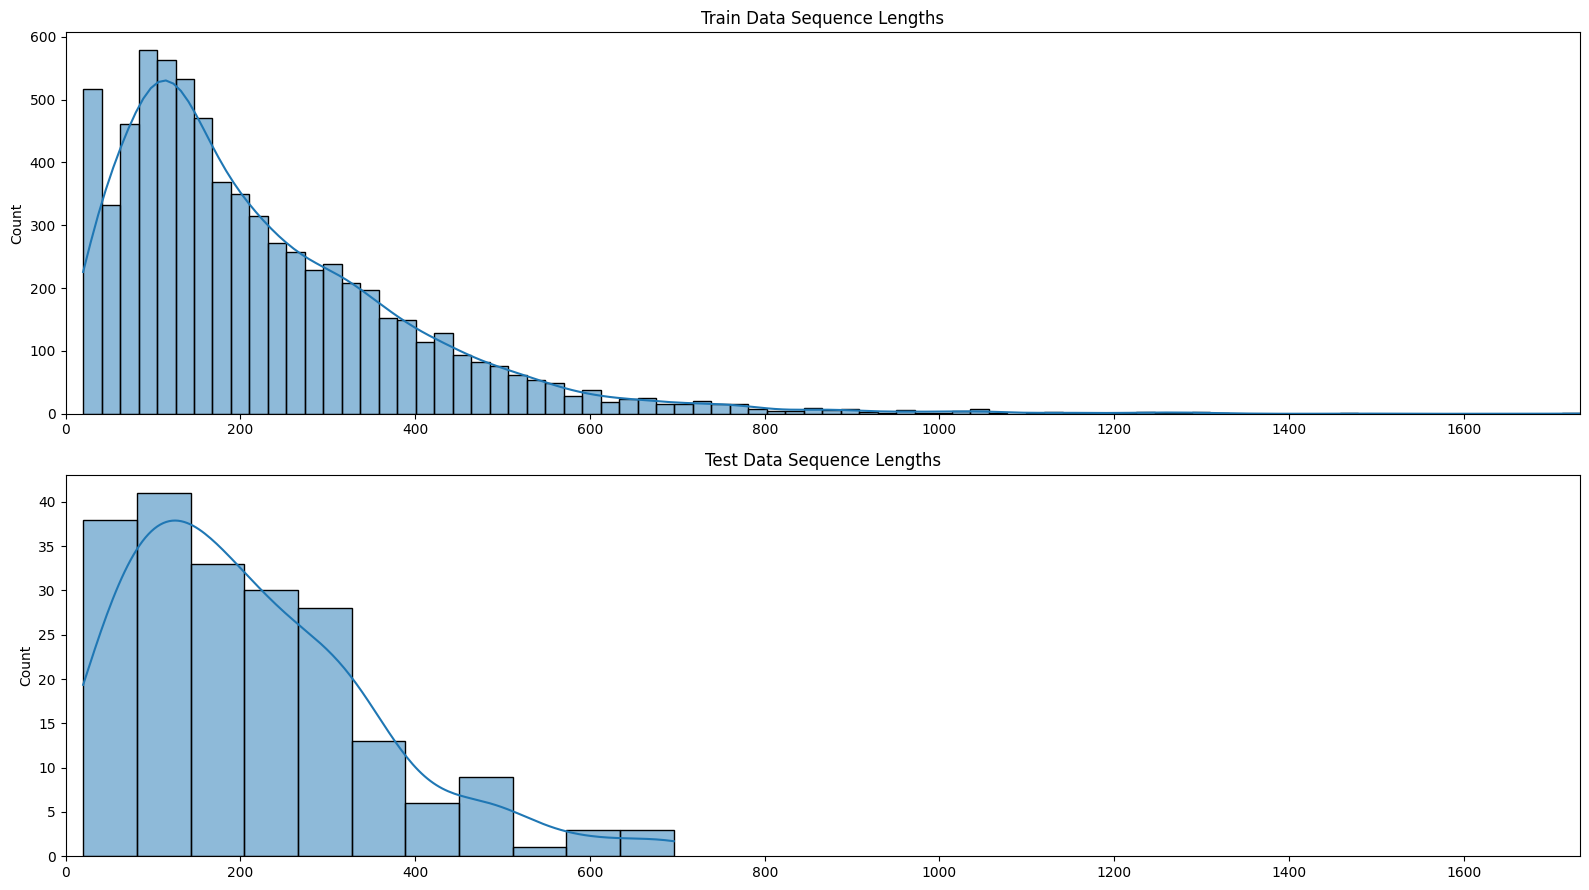

In [5]:
max_sequence_length = max(max(line_counts_train),max(line_counts_test)) 
min_sequence_length = min(min(line_counts_train),min(line_counts_test))

plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
sns.histplot(line_counts_train, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Train Data Sequence Lengths')
plt.tight_layout()
plt.subplot(2,1,2)
sns.histplot(line_counts_test, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Test Data Sequence Lengths')
plt.tight_layout()  

print('minimum sequence length:',min_sequence_length)
print('maximum sequence length:',max_sequence_length)


## Initial Processing and Feature Selection

### One hot encode or use probabilities?
In terms of preprocessing for the nueral network, although one hot encoding of the amino acid could be used, as it has the same dimensionality as the probabilities and less information, therefore the probabilities will be used. This will result in a 20 channel (number of different amino acids) by max_sequence_length size input layer. 

i.e shape (N, 20, max_sequence_length) where N is the batch size

### Convolution to observe local interactions
Using a conv1D kernel, the network can hopefully learn what the local interactions between the amino acid percentages signify, before passing the data onto some dense layers.

Finally as the training data is in a different order by PBD_ID to the corresponding labels, i will quickly reorder it to mean that the dataset is simpler to create.


In [6]:
test_dir = 'test'
train_dir = 'train'


for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_test', '')
        os.rename(os.path.join(test_dir, file_name), os.path.join(test_dir, new_file_name))

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_train', '')
        os.rename(os.path.join(train_dir, file_name), os.path.join(train_dir, new_file_name))
        


df = pd.read_csv('labels_train.csv')
df_sorted = df.sort_values('PDB_ID')
df_sorted.to_csv('labels_train_sorted.csv', index=False)


One hot encoding the output for training data and creating a reverse

In [7]:
def one_hot_encode_sequence(sequence, max_sequence_length):
    encoding = {'H': [1,0,0,0], 'E': [0,1,0,0], 'C': [0,0,1,0], ' ': [0,0,0,1]}
    encoded_sequence = []
    
    for char in sequence:
        encoded_sequence.extend(encoding[char])

    num_blanks = max_sequence_length - len(sequence)
    encoded_sequence.extend([0, 0, 0, 1] * num_blanks)
    
    return torch.tensor(encoded_sequence, dtype=torch.float32).reshape(max_sequence_length,4).T


def unencode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N x 4 x L torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(2)):  
        
        if encoded_sequence[0, 0, i] >= threshold:
            sequence += 'H'
        elif encoded_sequence[0, 1, i] >= threshold:
            sequence += 'E'
        elif encoded_sequence[0, 2, i] >= threshold:
            sequence += 'C'
        else:
            sequence += ' '
    return sequence


test_string = 'HCEC HCCCEC H'
test_encoded = one_hot_encode_sequence(test_string, 20)
print('Original:', test_string)
print('Encoded:', test_encoded)
print('Encoded shape:', test_encoded.shape)
test_encoded.unsqueeze_(0)
print('Decoded:', unencode_output(test_encoded))


Original: HCEC HCCCEC H
Encoded: tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
         1., 1.]])
Encoded shape: torch.Size([4, 20])
Decoded: HCEC HCCCEC H       


## Load the data as the PSSM data

We need to load 1733 rows of 20 probabilites from the file train

In [35]:
class PSSM_speedy(Dataset):
    """Position-Specific Scoring Matrix (PSSM) Dataset"""

    def __init__(self, pssm_root_dir, sec_struct_file_path, transform=None):
        """
        Args:
            pssm_root_dir (string): Directory with all the protein PSSM data.
            sec_struct_root_dir (string): Directory with all the protein secondary structure data. 
            transform (callable, optional): Optional transform to be applied on a sample. (not used here)           
        """
        self.pssm_root_dir = pssm_root_dir
        self.sec_struct_file_path = sec_struct_file_path
        self.transform = transform
        
        self.file_list = [file for file in os.listdir(pssm_root_dir) if file.endswith('.csv')]
        self.tensor_files_dir = os.path.join(pssm_root_dir, 'tensor_files')
        os.makedirs(self.tensor_files_dir, exist_ok=True)

    def preprocess_and_save_tensors(self): # Depending on system requirements may be memory intensive to run
        
        for file_name in self.file_list:
            
            pssm_csv_file = os.path.join(self.pssm_root_dir, file_name)
            pbd_id = os.path.splitext(file_name)[0]
            pbd_id = ''.join(pbd_id)

            pssm_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
            if os.path.exists(pssm_tensor_file_path) and os.path.exists(sec_struct_tensor_file_path):
                continue
            else:

                pssm_data = pd.read_csv(pssm_csv_file)
                pssm_data = pssm_data.drop(columns=['RES_NUM', 'AMINO_ACID'], axis=1)

                sec_struct_data = pd.read_csv(self.sec_struct_file_path)
                sec_struc_value = sec_struct_data.loc[sec_struct_data['PDB_ID'] == pbd_id, 'SEC_STRUCT'].values[0]
                encoded_sec_struc = one_hot_encode_sequence(sec_struc_value, max_sequence_length)

                num_zeros = max_sequence_length - len(pssm_data)
                if num_zeros > 0:
                    df_zeros = pd.DataFrame(0, index=range(num_zeros), columns=pssm_data.columns)
                    pssm_data = pd.concat([pssm_data, df_zeros], ignore_index=True)

                pssm_data = pssm_data.T.to_numpy()
                pssm_data = torch.tensor(pssm_data, dtype=torch.float32)

                torch.save(pssm_data, pssm_tensor_file_path)
                torch.save(encoded_sec_struc, sec_struct_tensor_file_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        pbd_id = os.path.splitext(file_name)[0]
        pbd_id = ''.join(pbd_id)

        tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
        pssm_data = torch.load(tensor_file_path)

        sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
        encoded_sec_struc = torch.load(sec_struct_tensor_file_path)
        input = pssm_data
        target = torch.argmax(encoded_sec_struc,dim=0)
        
        

        # sample = {
        #     'PDB_ID': pbd_id,
        #     'PSSM_Data': pssm_data,
        #     'Second Structure Data': encoded_sec_struc
        # }
    
        

        # if self.transform:
        #     sample = self.transform(sample)

        return input, target


speedy_dataset = PSSM_speedy(pssm_root_dir='/home/jamiemilsom/Deep_Learning_MSc/Kaggle/PSSM_Profiles/train',
                      sec_struct_file_path='/home/jamiemilsom/Deep_Learning_MSc/Kaggle/PSSM_Profiles/labels_train.csv')


#speedy_dataset.preprocess_and_save_tensors()

train_size = int(0.8 * len(speedy_dataset))
val_size = len(speedy_dataset) - train_size
train_dataset, val_dataset = random_split(speedy_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader =DataLoader(val_dataset,batch_size=64, shuffle=False)

In [36]:
import time

start_time = time.time()

for input, target in train_dataloader:
    continue
    
end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")


Elapsed time: 2.6129908561706543 seconds


In [38]:
count = 0
for input, target in train_dataloader:
    print(input.shape, target.shape)
    print(target)
    break
    

torch.Size([64, 20, 1733]) torch.Size([64, 1733])
tensor([[2, 2, 2,  ..., 3, 3, 3],
        [2, 1, 1,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        ...,
        [2, 1, 1,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 0, 0,  ..., 3, 3, 3]])


In [40]:
for input, target in val_dataloader:

    print('PSSM Data shape:', input.shape)
    print('Second Structure Data shape:', target.shape)
    
    print('Second Structure Data:', target)
    print(target[0,1])
    #print('unencoded:', unencode_output(target))


    break


PSSM Data shape: torch.Size([64, 20, 1733])
Second Structure Data shape: torch.Size([64, 1733])
Second Structure Data: tensor([[2, 2, 2,  ..., 3, 3, 3],
        [2, 1, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        ...,
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3]])
tensor(2)


## Creating the CNN Structure

In [ ]:
# import collections
# import torch.nn as nn

# dropout_prob = 0
# weight_decay = 1e-6
# lr=1e-5
# momentum=0
# dampening=0

# input_channels = 20
# max_sequence_length = 1750

# ConvNet = nn.Sequential(collections.OrderedDict([
#     ('conv1', nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=5, padding=2)),
#     ('relu1', nn.ReLU()),
#     ('conv2', nn.Conv1d(in_channels=32, out_channels=20, kernel_size=5, padding=2)),
#     ('relu2', nn.ReLU()),
#     ('conv3', nn.Conv1d(in_channels=20, out_channels=4, kernel_size=1)),
#     ('softmax', nn.Softmax(dim=1))
# ]))

# loss_fn = nn.CrossEntropyLoss()


# optimizer_conv = torch.optim.Adam(ConvNet.parameters()) #, weight_decay=weight_decay)
# #optimiser_conv = torch.optim.SGD(params=ConvNet.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
# print(ConvNet)


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dropout_prob = 0
weight_decay = 1e-6
lr=1e-5
momentum=0
dampening=0


class ProteinStructurePredictor(nn.Module):
    def __init__(self, input_channels=20, num_classes=4, max_seq_length=1750):
        super(ProteinStructurePredictor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, num_classes, kernel_size=5, padding=2),
            nn.ReLU(),

        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_classes * max_seq_length, num_classes * max_seq_length),
            nn.ReLU(),
            nn.Linear(num_classes * max_seq_length, num_classes * max_seq_length)
        )
        self.max_seq_length = max_seq_length

    def forward(self, x):
        
        x = self.conv_layers(x)
        
        x = self.flatten(x)
        x = self.fc_layers(x)
        x = x.view(-1, 4, self.max_seq_length)
        x = F.softmax(x, dim=1)
        return x

model = ProteinStructurePredictor(input_channels=20, num_classes=4, max_seq_length=max_sequence_length)
loss_fn = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.Adam(model.parameters()) #, weight_decay=weight_decay)

input_tensor = torch.randn(32, 20, 1733) 
print(input_tensor.shape)

output = model(input_tensor)
print(output.shape) 
print(output[0,:,:])

torch.Size([32, 20, 1733])
torch.Size([32, 4, 1733])
tensor([[0.2594, 0.2536, 0.2475,  ..., 0.2496, 0.2466, 0.2541],
        [0.2468, 0.2578, 0.2432,  ..., 0.2556, 0.2494, 0.2614],
        [0.2474, 0.2464, 0.2620,  ..., 0.2634, 0.2568, 0.2439],
        [0.2465, 0.2422, 0.2472,  ..., 0.2314, 0.2472, 0.2406]],
       grad_fn=<SliceBackward0>)


cool ok now they are in the same format :)))

In [57]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            total_train += labels.size(0) * labels.size(1)
            correct_train += torch.sum((predicted == labels)).item()

        avg_train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0) * labels.size(1)
                correct_val += torch.sum((predicted == labels)).item()

        avg_val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies



In [60]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer_conv, num_epochs=5)

Epoch [1/5], Train Loss: 0.8552, Train Acc: 0.8885, Val Loss: 0.8538, Val Acc: 0.8899
Epoch [2/5], Train Loss: 0.8552, Train Acc: 0.8885, Val Loss: 0.8538, Val Acc: 0.8899
Epoch [3/5], Train Loss: 0.8552, Train Acc: 0.8885, Val Loss: 0.8538, Val Acc: 0.8899
Epoch [4/5], Train Loss: 0.8552, Train Acc: 0.8885, Val Loss: 0.8538, Val Acc: 0.8899
Epoch [5/5], Train Loss: 0.8552, Train Acc: 0.8885, Val Loss: 0.8538, Val Acc: 0.8899


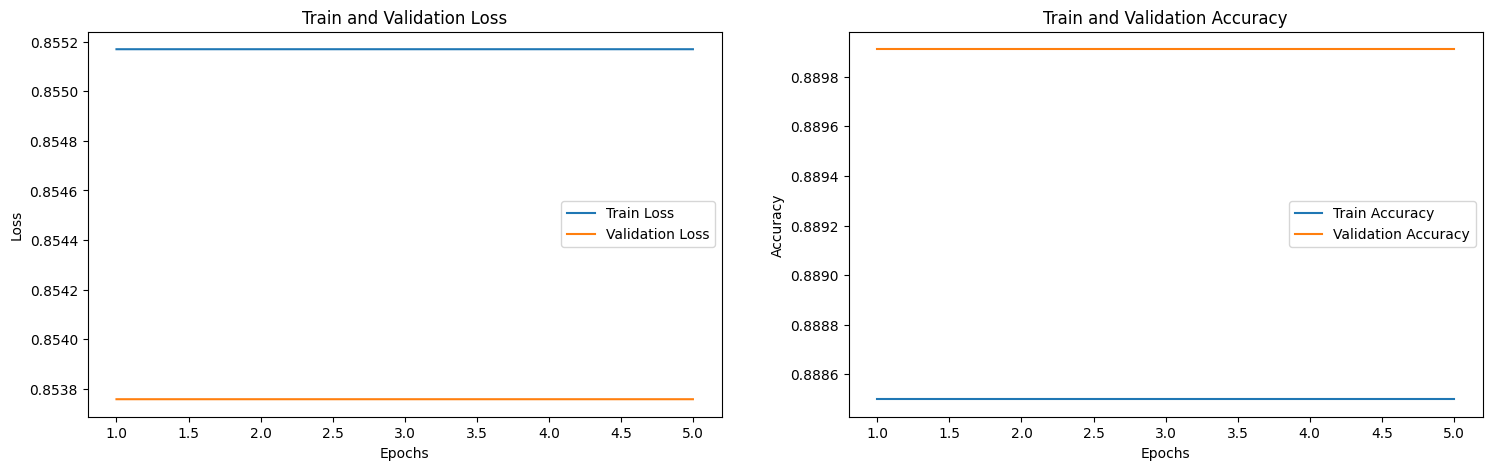

In [63]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

